In [1]:
import pickle
import time
import os

import numpy as np
import pydot
import graphviz
import glob
from unidecode import unidecode
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.preprocessing import sequence, text
from keras.utils import np_utils, plot_model
from keras.wrappers.scikit_learn import KerasClassifier

from classes import *

# fix random seed for reproducibility
np.random.seed(7)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#para usar solo una GPU
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf 
from keras.backend.tensorflow_backend import set_session 
config = tf.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 1
set_session(tf.Session(config = config))

In [3]:
#Loading the pickle file with the dictionary Journal - List of headlines
#f = open('titulares_creados/headlines_final.pckl', 'rb')
f = open('merged_headlines.pckl', 'rb')
lista_periodicos = pickle.load(f)
f.close()

In [4]:
#Creating the Headlines object from the pickle file
ep = 'http://ep00.epimg.net/rss/elpais/portada.xml'
em = 'http://estaticos.elmundo.es/elmundo/rss/portada.xml'
lv = 'http://www.lavanguardia.com/mvc/feed/rss/home.xml'
lr = 'http://www.larazon.es/rss/portada.xml'
abc = 'http://www.abc.es/rss/feeds/abcPortada.xml'

urls = [ep, em, lv, lr, abc]
journals = ['El Pais', 'El Mundo', 'La Vanguardia', 'La Razon', 'ABC']

data = Headlines(periodicos=journals, urls=urls, titulares=lista_periodicos) 

In [5]:
#Creating dataframe from the headlines
periodicos_df = Headlines.dataframing_headlines(data)
periodicos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183206 entries, 0 to 183205
Data columns (total 2 columns):
Headline    183206 non-null object
Journal     183206 non-null object
dtypes: object(2)
memory usage: 2.8+ MB


In [6]:
# How many headlines there are of each journal?
# We should limit the number of headlines in each journal to the minimum number available for one of the classes
min_number = Headlines.min_hl_number(data, periodicos_df) 

El Pais 21406
El Mundo 60946
La Vanguardia 68746
La Razon 11026
ABC 21082


In [7]:
min_per_df = Headlines.keeping_min_headlines(data, periodicos_df, min_number)
min_per_df

,Headline,Journal
0,Los inmigrantes a bordo del Dattilo: «Están co...,ABC
1,El ministro del Interior belga: España “ha ido...,La Vanguardia
2,Suecia tumba a Suiza de rebote,El Mundo
3,El Parlamento británico insiste en que Mark Zu...,La Vanguardia
4,La vitamina que nos regalan los rayos del sol,El Mundo
5,El senador Agramunt niega sobornos con prostit...,ABC
6,Anula una multa de tráfico porque la señal est...,El Mundo
7,El extraordinario verano del 77: así vivimos l...,El Mundo
8,"Muere Luis de Marcos, el hombre que pidió a Ra...",ABC
9,Francia investiga el posible amaño del PSG - E...,El Mundo


In [8]:
# Obtaining concantenated headlines in order to build the dictionary
concatenated_hl = Headlines.concatenate_headlines(data, df = min_per_df)

In [9]:
# Building dictionary from headlines
sequence_hl = Text_Sequence(concatenated_hl)
dictionary_hl, len_dict = Text_Sequence.creating_dict(sequence_hl)
print ('The dictionary contains', len_dict, 'words')

The dictionary contains 34933 words


In [10]:
# Mapping headlines to integer
x_int = Headlines.headlines_to_int(data, min_per_df, dictionary_hl)
x_int

array([list([21178, 18984, 2125, 6430, 10954, 10676, 14404, 9564, 31133, 5574, 7253]),
       list([13054, 22671, 10954, 19263, 5950, 14213, 17237, 18171, 11038, 20589]),
       list([31460, 33194, 2125, 31520, 10694, 28030]), ...,
       list([13327, 20298, 24436, 24949, 14682, 2125, 21178, 23800, 10694, 20298, 10400, 10694, 31834]),
       list([22763, 33362, 11907, 10694, 29296, 24949, 21178, 23646]),
       list([13054, 1776, 10694, 20447, 23235, 13381, 12934, 20305, 30174, 13525, 13381, 29296, 10694, 26249])],
      dtype=object)

In [11]:
# Labelling journal names 
y_int = Headlines.y_to_int(data, min_per_df)
y_int

array([4, 2, 1, ..., 1, 0, 4])

In [12]:
y_int[0:20]

array([4, 2, 1, 2, 1, 4, 1, 1, 4, 1, 3, 0, 0, 3, 3, 1, 2, 2, 4, 3])

In [13]:
y_onehot = np_utils.to_categorical(y_int)
y_onehot

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [14]:
# In Keras, sequences must have the same length
# Searching for the longest length of headlines
max_headline_lenght = Headlines.max_hl_length(data, x_int)

The longest headline consists of 28 words


In [15]:
#truncate and pad input sequences
x_samelength = sequence.pad_sequences(x_int, maxlen=max_headline_lenght)
x_samelength

array([[    0,     0,     0, ..., 31133,  5574,  7253],
       [    0,     0,     0, ..., 18171, 11038, 20589],
       [    0,     0,     0, ..., 31520, 10694, 28030],
       ...,
       [    0,     0,     0, ..., 10400, 10694, 31834],
       [    0,     0,     0, ..., 24949, 21178, 23646],
       [    0,     0,     0, ..., 29296, 10694, 26249]], dtype=int32)

In [16]:
# Dividing between training and test set
#x_train, x_test, y_train, y_test = Headlines.splitting_data(data, x_samelength, y_onehot, 0.1)
x_train, x_val, x_test, y_train, y_val, y_test = Headlines.splitting_data_threesets(data, x_samelength, y_onehot, 0.8)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
# Loading a pre-trained Spanish embedding 
words, embeddings = pickle.load(open('polyglot-es.pkl', 'rb'), encoding='latin1')
print("Emebddings shape is {}".format(embeddings.shape))

Emebddings shape is (100004, 64)


In [18]:
#Defining Adam optimizer
epochss = 1000
learning_rate = 1e-5
decay_rate = learning_rate/epochss
adamm = Adam(lr=learning_rate, decay=decay_rate)

In [19]:
#create the LSTM model
def baseline_model():
#first layer: embedded layer. uses 5 length vectors to represent each word
    embedding_vector_length = 64
    model=Sequential()
    
    #model.add(Embedding(len_dict, embedding_vector_length, input_length=max_headline_lenght))
    model.add(Embedding(100004, embedding_vector_length, trainable =False, weights= [embeddings], input_length=max_headline_lenght))
    model.add(Dropout(0.5))
    
    model.add(Conv1D(filters=embedding_vector_length, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.15))

#Next layer: LSTM layer with 100 memory units
    model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.0, activation=None))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))


#Because we used a one-hot encoding for our iris dataset, the output layer must create 3 output values, one for each class.
    model.add(Dense(5))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))

#Because it is a binary classification problem, log loss is used as the loss function 

#Because it is a multi-class classification problem, categorical cross entropy is used as the loss function
    model.compile(loss='categorical_crossentropy', optimizer = adamm, metrics=['accuracy'])
    print(model.summary())
    return model

In [20]:
# WAY 2: no sklearn wrapper, simply using keras
model = baseline_model()
#history = model.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=200, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 64)            6400256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 64)            12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 64)            256       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
__________

In [21]:
# define the checkpoint
dirr = os.path.dirname(os.path.realpath('__file__'))
filepath = os.path.join(dirr, 'LSTM_journals','weights-improvement-{epoch:03d}-{val_acc:.4f}.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [22]:
#history = model.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=epochss, batch_size=128, callbacks=callbacks_list)

history = model.fit(x_train, y_train, validation_data= (x_val, y_val), epochs=epochss, batch_size=128, callbacks=callbacks_list)

Train on 44104 samples, validate on 5513 samples
Epoch 1/1000
44104/44104 [==============================] - 20s 449us/step - loss: 1.9402 - acc: 0.2000 - val_loss: 1.6251 - val_acc: 0.2017

Epoch 00001: val_acc improved from -inf to 0.20171, saving model to /home/angela/repos/headlines_classificator/LSTM_journals/weights-improvement-001-0.2017.hdf5
Epoch 2/1000
44104/44104 [==============================] - 18s 415us/step - loss: 1.9325 - acc: 0.1997 - val_loss: 1.6252 - val_acc: 0.2017

Epoch 00002: val_acc did not improve
Epoch 3/1000
44104/44104 [==============================] - 18s 415us/step - loss: 1.9228 - acc: 0.2015 - val_loss: 1.6252 - val_acc: 0.2017

Epoch 00003: val_acc did not improve
Epoch 4/1000
44104/44104 [==============================] - 18s 417us/step - loss: 1.9258 - acc: 0.1985 - val_loss: 1.6250 - val_acc: 0.2019

Epoch 00004: val_acc improved from 0.20171 to 0.20189, saving model to /home/angela/repos/headlines_classificator/LSTM_journals/weights-improvement-

44104/44104 [==============================] - 19s 439us/step - loss: 1.7590 - acc: 0.2005 - val_loss: 1.6146 - val_acc: 0.2021

Epoch 00044: val_acc did not improve
Epoch 45/1000
44104/44104 [==============================] - 19s 432us/step - loss: 1.7503 - acc: 0.1996 - val_loss: 1.6146 - val_acc: 0.2021

Epoch 00045: val_acc did not improve
Epoch 46/1000
44104/44104 [==============================] - 19s 433us/step - loss: 1.7502 - acc: 0.2005 - val_loss: 1.6142 - val_acc: 0.2021

Epoch 00046: val_acc did not improve
Epoch 47/1000
44104/44104 [==============================] - 19s 425us/step - loss: 1.7468 - acc: 0.1988 - val_loss: 1.6141 - val_acc: 0.2021

Epoch 00047: val_acc did not improve
Epoch 48/1000
44104/44104 [==============================] - 19s 434us/step - loss: 1.7453 - acc: 0.2003 - val_loss: 1.6134 - val_acc: 0.2021

Epoch 00048: val_acc did not improve
Epoch 49/1000
44104/44104 [==============================] - 19s 431us/step - loss: 1.7464 - acc: 0.1976 - val_los

44104/44104 [==============================] - 19s 432us/step - loss: 1.6534 - acc: 0.1977 - val_loss: 1.6108 - val_acc: 0.2021

Epoch 00089: val_acc did not improve
Epoch 90/1000
44104/44104 [==============================] - 19s 431us/step - loss: 1.6521 - acc: 0.2031 - val_loss: 1.6108 - val_acc: 0.2021

Epoch 00090: val_acc did not improve
Epoch 91/1000
44104/44104 [==============================] - 19s 431us/step - loss: 1.6520 - acc: 0.2012 - val_loss: 1.6106 - val_acc: 0.2021

Epoch 00091: val_acc did not improve
Epoch 92/1000
44104/44104 [==============================] - 20s 444us/step - loss: 1.6500 - acc: 0.1958 - val_loss: 1.6106 - val_acc: 0.2021

Epoch 00092: val_acc did not improve
Epoch 93/1000
44104/44104 [==============================] - 19s 434us/step - loss: 1.6461 - acc: 0.2007 - val_loss: 1.6106 - val_acc: 0.2021

Epoch 00093: val_acc did not improve
Epoch 94/1000
44104/44104 [==============================] - 19s 435us/step - loss: 1.6510 - acc: 0.1967 - val_los

44104/44104 [==============================] - 19s 433us/step - loss: 1.6238 - acc: 0.1999 - val_loss: 1.6096 - val_acc: 0.2021

Epoch 00134: val_acc did not improve
Epoch 135/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.6221 - acc: 0.2008 - val_loss: 1.6096 - val_acc: 0.2021

Epoch 00135: val_acc did not improve
Epoch 136/1000
44104/44104 [==============================] - 19s 432us/step - loss: 1.6230 - acc: 0.1995 - val_loss: 1.6095 - val_acc: 0.2021

Epoch 00136: val_acc did not improve
Epoch 137/1000
44104/44104 [==============================] - 19s 433us/step - loss: 1.6212 - acc: 0.2013 - val_loss: 1.6095 - val_acc: 0.2021

Epoch 00137: val_acc did not improve
Epoch 138/1000
44104/44104 [==============================] - 19s 435us/step - loss: 1.6214 - acc: 0.2003 - val_loss: 1.6095 - val_acc: 0.2021

Epoch 00138: val_acc did not improve
Epoch 139/1000
44104/44104 [==============================] - 19s 432us/step - loss: 1.6223 - acc: 0.1966 - va

44104/44104 [==============================] - 19s 430us/step - loss: 1.6139 - acc: 0.2017 - val_loss: 1.6095 - val_acc: 0.2021

Epoch 00179: val_acc did not improve
Epoch 180/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.6136 - acc: 0.2043 - val_loss: 1.6095 - val_acc: 0.2021

Epoch 00180: val_acc did not improve
Epoch 181/1000
44104/44104 [==============================] - 19s 434us/step - loss: 1.6135 - acc: 0.2026 - val_loss: 1.6095 - val_acc: 0.2021

Epoch 00181: val_acc did not improve
Epoch 182/1000
44104/44104 [==============================] - 19s 425us/step - loss: 1.6119 - acc: 0.2078 - val_loss: 1.6095 - val_acc: 0.2021

Epoch 00182: val_acc did not improve
Epoch 183/1000
44104/44104 [==============================] - 19s 427us/step - loss: 1.6139 - acc: 0.2024 - val_loss: 1.6095 - val_acc: 0.2021

Epoch 00183: val_acc did not improve
Epoch 184/1000
44104/44104 [==============================] - 19s 426us/step - loss: 1.6126 - acc: 0.2047 - va

44104/44104 [==============================] - 19s 431us/step - loss: 1.6093 - acc: 0.2104 - val_loss: 1.6089 - val_acc: 0.2061

Epoch 00221: val_acc did not improve
Epoch 222/1000
44104/44104 [==============================] - 19s 435us/step - loss: 1.6094 - acc: 0.2098 - val_loss: 1.6084 - val_acc: 0.2128

Epoch 00222: val_acc improved from 0.20697 to 0.21277, saving model to /home/angela/repos/headlines_classificator/LSTM_journals/weights-improvement-222-0.2128.hdf5
Epoch 223/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.6093 - acc: 0.2101 - val_loss: 1.6088 - val_acc: 0.2073

Epoch 00223: val_acc did not improve
Epoch 224/1000
44104/44104 [==============================] - 19s 429us/step - loss: 1.6090 - acc: 0.2122 - val_loss: 1.6089 - val_acc: 0.2066

Epoch 00224: val_acc did not improve
Epoch 225/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.6096 - acc: 0.2111 - val_loss: 1.6088 - val_acc: 0.2075

Epoch 00225: val_acc

44104/44104 [==============================] - 19s 435us/step - loss: 1.6061 - acc: 0.2205 - val_loss: 1.6072 - val_acc: 0.2104

Epoch 00265: val_acc did not improve
Epoch 266/1000
44104/44104 [==============================] - 19s 429us/step - loss: 1.6058 - acc: 0.2157 - val_loss: 1.6068 - val_acc: 0.2119

Epoch 00266: val_acc did not improve
Epoch 267/1000
44104/44104 [==============================] - 19s 435us/step - loss: 1.6054 - acc: 0.2174 - val_loss: 1.6068 - val_acc: 0.2115

Epoch 00267: val_acc did not improve
Epoch 268/1000
44104/44104 [==============================] - 19s 433us/step - loss: 1.6049 - acc: 0.2193 - val_loss: 1.6073 - val_acc: 0.2102

Epoch 00268: val_acc did not improve
Epoch 269/1000
44104/44104 [==============================] - 19s 426us/step - loss: 1.6059 - acc: 0.2164 - val_loss: 1.6070 - val_acc: 0.2104

Epoch 00269: val_acc did not improve
Epoch 270/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.6052 - acc: 0.2196 - va

44104/44104 [==============================] - 19s 434us/step - loss: 1.6034 - acc: 0.2217 - val_loss: 1.6035 - val_acc: 0.2273

Epoch 00304: val_acc improved from 0.22601 to 0.22728, saving model to /home/angela/repos/headlines_classificator/LSTM_journals/weights-improvement-304-0.2273.hdf5
Epoch 305/1000
44104/44104 [==============================] - 19s 429us/step - loss: 1.6037 - acc: 0.2235 - val_loss: 1.6031 - val_acc: 0.2295

Epoch 00305: val_acc improved from 0.22728 to 0.22946, saving model to /home/angela/repos/headlines_classificator/LSTM_journals/weights-improvement-305-0.2295.hdf5
Epoch 306/1000
44104/44104 [==============================] - 19s 433us/step - loss: 1.6036 - acc: 0.2234 - val_loss: 1.6036 - val_acc: 0.2264

Epoch 00306: val_acc did not improve
Epoch 307/1000
44104/44104 [==============================] - 19s 435us/step - loss: 1.6034 - acc: 0.2222 - val_loss: 1.6040 - val_acc: 0.2264

Epoch 00307: val_acc did not improve
Epoch 308/1000
44104/44104 [=========

44104/44104 [==============================] - 19s 430us/step - loss: 1.6019 - acc: 0.2284 - val_loss: 1.6004 - val_acc: 0.2322

Epoch 00346: val_acc did not improve
Epoch 347/1000
44104/44104 [==============================] - 19s 428us/step - loss: 1.6009 - acc: 0.2276 - val_loss: 1.6013 - val_acc: 0.2320

Epoch 00347: val_acc did not improve
Epoch 348/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.6014 - acc: 0.2281 - val_loss: 1.6018 - val_acc: 0.2334

Epoch 00348: val_acc did not improve
Epoch 349/1000
44104/44104 [==============================] - 19s 433us/step - loss: 1.6014 - acc: 0.2259 - val_loss: 1.6013 - val_acc: 0.2322

Epoch 00349: val_acc did not improve
Epoch 350/1000
44104/44104 [==============================] - 19s 432us/step - loss: 1.6022 - acc: 0.2267 - val_loss: 1.6011 - val_acc: 0.2318

Epoch 00350: val_acc did not improve
Epoch 351/1000
44104/44104 [==============================] - 19s 429us/step - loss: 1.6014 - acc: 0.2273 - va

44104/44104 [==============================] - 19s 433us/step - loss: 1.6001 - acc: 0.2327 - val_loss: 1.5991 - val_acc: 0.2411

Epoch 00390: val_acc improved from 0.23798 to 0.24107, saving model to /home/angela/repos/headlines_classificator/LSTM_journals/weights-improvement-390-0.2411.hdf5
Epoch 391/1000
44104/44104 [==============================] - 19s 434us/step - loss: 1.5989 - acc: 0.2322 - val_loss: 1.5996 - val_acc: 0.2373

Epoch 00391: val_acc did not improve
Epoch 392/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.5999 - acc: 0.2324 - val_loss: 1.5996 - val_acc: 0.2387

Epoch 00392: val_acc did not improve
Epoch 393/1000
44104/44104 [==============================] - 19s 428us/step - loss: 1.5993 - acc: 0.2358 - val_loss: 1.5997 - val_acc: 0.2362

Epoch 00393: val_acc did not improve
Epoch 394/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.5995 - acc: 0.2300 - val_loss: 1.5989 - val_acc: 0.2396

Epoch 00394: val_acc

44104/44104 [==============================] - 19s 434us/step - loss: 1.5987 - acc: 0.2354 - val_loss: 1.5977 - val_acc: 0.2436

Epoch 00431: val_acc did not improve
Epoch 432/1000
44104/44104 [==============================] - 19s 436us/step - loss: 1.5985 - acc: 0.2390 - val_loss: 1.5983 - val_acc: 0.2420

Epoch 00432: val_acc did not improve
Epoch 433/1000
44104/44104 [==============================] - 19s 429us/step - loss: 1.5980 - acc: 0.2364 - val_loss: 1.5981 - val_acc: 0.2431

Epoch 00433: val_acc did not improve
Epoch 434/1000
44104/44104 [==============================] - 19s 428us/step - loss: 1.5986 - acc: 0.2378 - val_loss: 1.5980 - val_acc: 0.2436

Epoch 00434: val_acc did not improve
Epoch 435/1000
44104/44104 [==============================] - 19s 432us/step - loss: 1.5984 - acc: 0.2348 - val_loss: 1.5978 - val_acc: 0.2434

Epoch 00435: val_acc did not improve
Epoch 436/1000
44104/44104 [==============================] - 19s 432us/step - loss: 1.5986 - acc: 0.2367 - va


Epoch 00475: val_acc did not improve
Epoch 476/1000
44104/44104 [==============================] - 19s 431us/step - loss: 1.5968 - acc: 0.2405 - val_loss: 1.5964 - val_acc: 0.2467

Epoch 00476: val_acc did not improve
Epoch 477/1000
44104/44104 [==============================] - 19s 434us/step - loss: 1.5967 - acc: 0.2396 - val_loss: 1.5962 - val_acc: 0.2454

Epoch 00477: val_acc did not improve
Epoch 478/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.5974 - acc: 0.2401 - val_loss: 1.5961 - val_acc: 0.2461

Epoch 00478: val_acc did not improve
Epoch 479/1000
44104/44104 [==============================] - 19s 432us/step - loss: 1.5960 - acc: 0.2405 - val_loss: 1.5961 - val_acc: 0.2458

Epoch 00479: val_acc did not improve
Epoch 480/1000
44104/44104 [==============================] - 19s 436us/step - loss: 1.5965 - acc: 0.2390 - val_loss: 1.5959 - val_acc: 0.2467

Epoch 00480: val_acc did not improve
Epoch 481/1000
44104/44104 [=============================

44104/44104 [==============================] - 19s 434us/step - loss: 1.5962 - acc: 0.2431 - val_loss: 1.5947 - val_acc: 0.2458

Epoch 00521: val_acc did not improve
Epoch 522/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.5945 - acc: 0.2428 - val_loss: 1.5948 - val_acc: 0.2447

Epoch 00522: val_acc did not improve
Epoch 523/1000
44104/44104 [==============================] - 19s 432us/step - loss: 1.5953 - acc: 0.2415 - val_loss: 1.5949 - val_acc: 0.2451

Epoch 00523: val_acc did not improve
Epoch 524/1000
44104/44104 [==============================] - 19s 433us/step - loss: 1.5954 - acc: 0.2427 - val_loss: 1.5946 - val_acc: 0.2454

Epoch 00524: val_acc did not improve
Epoch 525/1000
44104/44104 [==============================] - 19s 431us/step - loss: 1.5941 - acc: 0.2424 - val_loss: 1.5946 - val_acc: 0.2445

Epoch 00525: val_acc did not improve
Epoch 526/1000
44104/44104 [==============================] - 19s 428us/step - loss: 1.5958 - acc: 0.2413 - va

44104/44104 [==============================] - 19s 433us/step - loss: 1.5936 - acc: 0.2453 - val_loss: 1.5929 - val_acc: 0.2449

Epoch 00566: val_acc did not improve
Epoch 567/1000
44104/44104 [==============================] - 19s 427us/step - loss: 1.5942 - acc: 0.2439 - val_loss: 1.5930 - val_acc: 0.2438

Epoch 00567: val_acc did not improve
Epoch 568/1000
44104/44104 [==============================] - 19s 431us/step - loss: 1.5940 - acc: 0.2428 - val_loss: 1.5929 - val_acc: 0.2447

Epoch 00568: val_acc did not improve
Epoch 569/1000
44104/44104 [==============================] - 19s 433us/step - loss: 1.5944 - acc: 0.2456 - val_loss: 1.5930 - val_acc: 0.2440

Epoch 00569: val_acc did not improve
Epoch 570/1000
44104/44104 [==============================] - 19s 431us/step - loss: 1.5938 - acc: 0.2470 - val_loss: 1.5926 - val_acc: 0.2483

Epoch 00570: val_acc improved from 0.24723 to 0.24832, saving model to /home/angela/repos/headlines_classificator/LSTM_journals/weights-improvement

44104/44104 [==============================] - 19s 431us/step - loss: 1.5934 - acc: 0.2452 - val_loss: 1.5921 - val_acc: 0.2490

Epoch 00608: val_acc did not improve
Epoch 609/1000
44104/44104 [==============================] - 19s 431us/step - loss: 1.5934 - acc: 0.2442 - val_loss: 1.5919 - val_acc: 0.2476

Epoch 00609: val_acc did not improve
Epoch 610/1000
44104/44104 [==============================] - 19s 428us/step - loss: 1.5936 - acc: 0.2444 - val_loss: 1.5918 - val_acc: 0.2500

Epoch 00610: val_acc did not improve
Epoch 611/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.5935 - acc: 0.2456 - val_loss: 1.5922 - val_acc: 0.2487

Epoch 00611: val_acc did not improve
Epoch 612/1000
44104/44104 [==============================] - 19s 429us/step - loss: 1.5933 - acc: 0.2447 - val_loss: 1.5920 - val_acc: 0.2492

Epoch 00612: val_acc did not improve
Epoch 613/1000
44104/44104 [==============================] - 19s 429us/step - loss: 1.5926 - acc: 0.2470 - va

44104/44104 [==============================] - 19s 430us/step - loss: 1.5927 - acc: 0.2466 - val_loss: 1.5911 - val_acc: 0.2519

Epoch 00651: val_acc did not improve
Epoch 652/1000
44104/44104 [==============================] - 19s 436us/step - loss: 1.5928 - acc: 0.2491 - val_loss: 1.5909 - val_acc: 0.2512

Epoch 00652: val_acc did not improve
Epoch 653/1000
44104/44104 [==============================] - 19s 432us/step - loss: 1.5930 - acc: 0.2456 - val_loss: 1.5908 - val_acc: 0.2501

Epoch 00653: val_acc did not improve
Epoch 654/1000
44104/44104 [==============================] - 19s 426us/step - loss: 1.5933 - acc: 0.2498 - val_loss: 1.5910 - val_acc: 0.2501

Epoch 00654: val_acc did not improve
Epoch 655/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.5925 - acc: 0.2471 - val_loss: 1.5905 - val_acc: 0.2572

Epoch 00655: val_acc improved from 0.25449 to 0.25721, saving model to /home/angela/repos/headlines_classificator/LSTM_journals/weights-improvement

44104/44104 [==============================] - 19s 429us/step - loss: 1.5926 - acc: 0.2478 - val_loss: 1.5902 - val_acc: 0.2525

Epoch 00693: val_acc did not improve
Epoch 694/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.5922 - acc: 0.2488 - val_loss: 1.5901 - val_acc: 0.2527

Epoch 00694: val_acc did not improve
Epoch 695/1000
44104/44104 [==============================] - 19s 433us/step - loss: 1.5924 - acc: 0.2470 - val_loss: 1.5903 - val_acc: 0.2519

Epoch 00695: val_acc did not improve
Epoch 696/1000
44104/44104 [==============================] - 19s 437us/step - loss: 1.5924 - acc: 0.2493 - val_loss: 1.5906 - val_acc: 0.2519

Epoch 00696: val_acc did not improve
Epoch 697/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.5918 - acc: 0.2475 - val_loss: 1.5897 - val_acc: 0.2581

Epoch 00697: val_acc did not improve
Epoch 698/1000
44104/44104 [==============================] - 19s 427us/step - loss: 1.5920 - acc: 0.2486 - va

44104/44104 [==============================] - 19s 432us/step - loss: 1.5919 - acc: 0.2488 - val_loss: 1.5893 - val_acc: 0.2558

Epoch 00737: val_acc did not improve
Epoch 738/1000
44104/44104 [==============================] - 19s 433us/step - loss: 1.5900 - acc: 0.2505 - val_loss: 1.5897 - val_acc: 0.2512

Epoch 00738: val_acc did not improve
Epoch 739/1000
44104/44104 [==============================] - 19s 434us/step - loss: 1.5904 - acc: 0.2488 - val_loss: 1.5893 - val_acc: 0.2547

Epoch 00739: val_acc did not improve
Epoch 740/1000
44104/44104 [==============================] - 19s 434us/step - loss: 1.5923 - acc: 0.2495 - val_loss: 1.5896 - val_acc: 0.2496

Epoch 00740: val_acc did not improve
Epoch 741/1000
44104/44104 [==============================] - 19s 432us/step - loss: 1.5916 - acc: 0.2476 - val_loss: 1.5894 - val_acc: 0.2563

Epoch 00741: val_acc did not improve
Epoch 742/1000
44104/44104 [==============================] - 19s 433us/step - loss: 1.5914 - acc: 0.2485 - va

44104/44104 [==============================] - 19s 429us/step - loss: 1.5914 - acc: 0.2473 - val_loss: 1.5886 - val_acc: 0.2559

Epoch 00782: val_acc did not improve
Epoch 783/1000
44104/44104 [==============================] - 19s 437us/step - loss: 1.5913 - acc: 0.2475 - val_loss: 1.5891 - val_acc: 0.2510

Epoch 00783: val_acc did not improve
Epoch 784/1000
44104/44104 [==============================] - 19s 432us/step - loss: 1.5915 - acc: 0.2481 - val_loss: 1.5885 - val_acc: 0.2530

Epoch 00784: val_acc did not improve
Epoch 785/1000
44104/44104 [==============================] - 19s 435us/step - loss: 1.5906 - acc: 0.2499 - val_loss: 1.5889 - val_acc: 0.2500

Epoch 00785: val_acc did not improve
Epoch 786/1000
44104/44104 [==============================] - 19s 431us/step - loss: 1.5914 - acc: 0.2501 - val_loss: 1.5889 - val_acc: 0.2494

Epoch 00786: val_acc did not improve
Epoch 787/1000
44104/44104 [==============================] - 19s 428us/step - loss: 1.5910 - acc: 0.2507 - va

44104/44104 [==============================] - 19s 429us/step - loss: 1.5899 - acc: 0.2524 - val_loss: 1.5880 - val_acc: 0.2549

Epoch 00827: val_acc did not improve
Epoch 828/1000
44104/44104 [==============================] - 19s 431us/step - loss: 1.5899 - acc: 0.2523 - val_loss: 1.5879 - val_acc: 0.2552

Epoch 00828: val_acc did not improve
Epoch 829/1000
44104/44104 [==============================] - 19s 436us/step - loss: 1.5898 - acc: 0.2519 - val_loss: 1.5880 - val_acc: 0.2532

Epoch 00829: val_acc did not improve
Epoch 830/1000
44104/44104 [==============================] - 19s 432us/step - loss: 1.5902 - acc: 0.2525 - val_loss: 1.5876 - val_acc: 0.2563

Epoch 00830: val_acc did not improve
Epoch 831/1000
44104/44104 [==============================] - 19s 432us/step - loss: 1.5907 - acc: 0.2475 - val_loss: 1.5885 - val_acc: 0.2547

Epoch 00831: val_acc did not improve
Epoch 832/1000
44104/44104 [==============================] - 19s 432us/step - loss: 1.5904 - acc: 0.2476 - va

44104/44104 [==============================] - 19s 431us/step - loss: 1.5892 - acc: 0.2518 - val_loss: 1.5877 - val_acc: 0.2512

Epoch 00872: val_acc did not improve
Epoch 873/1000
44104/44104 [==============================] - 19s 433us/step - loss: 1.5901 - acc: 0.2517 - val_loss: 1.5877 - val_acc: 0.2543

Epoch 00873: val_acc did not improve
Epoch 874/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.5892 - acc: 0.2537 - val_loss: 1.5870 - val_acc: 0.2579

Epoch 00874: val_acc did not improve
Epoch 875/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.5897 - acc: 0.2505 - val_loss: 1.5874 - val_acc: 0.2554

Epoch 00875: val_acc did not improve
Epoch 876/1000
44104/44104 [==============================] - 19s 429us/step - loss: 1.5900 - acc: 0.2512 - val_loss: 1.5874 - val_acc: 0.2547

Epoch 00876: val_acc did not improve
Epoch 877/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.5908 - acc: 0.2519 - va

44104/44104 [==============================] - 19s 432us/step - loss: 1.5890 - acc: 0.2533 - val_loss: 1.5870 - val_acc: 0.2547

Epoch 00917: val_acc did not improve
Epoch 918/1000
44104/44104 [==============================] - 19s 436us/step - loss: 1.5903 - acc: 0.2529 - val_loss: 1.5870 - val_acc: 0.2556

Epoch 00918: val_acc did not improve
Epoch 919/1000
44104/44104 [==============================] - 19s 432us/step - loss: 1.5885 - acc: 0.2550 - val_loss: 1.5871 - val_acc: 0.2530

Epoch 00919: val_acc did not improve
Epoch 920/1000
44104/44104 [==============================] - 19s 432us/step - loss: 1.5897 - acc: 0.2537 - val_loss: 1.5869 - val_acc: 0.2532

Epoch 00920: val_acc did not improve
Epoch 921/1000
44104/44104 [==============================] - 19s 431us/step - loss: 1.5893 - acc: 0.2521 - val_loss: 1.5874 - val_acc: 0.2523

Epoch 00921: val_acc did not improve
Epoch 922/1000
44104/44104 [==============================] - 19s 435us/step - loss: 1.5892 - acc: 0.2516 - va

44104/44104 [==============================] - 19s 433us/step - loss: 1.5880 - acc: 0.2555 - val_loss: 1.5864 - val_acc: 0.2552

Epoch 00961: val_acc did not improve
Epoch 962/1000
44104/44104 [==============================] - 19s 437us/step - loss: 1.5896 - acc: 0.2510 - val_loss: 1.5861 - val_acc: 0.2550

Epoch 00962: val_acc did not improve
Epoch 963/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.5894 - acc: 0.2525 - val_loss: 1.5866 - val_acc: 0.2558

Epoch 00963: val_acc did not improve
Epoch 964/1000
44104/44104 [==============================] - 19s 430us/step - loss: 1.5888 - acc: 0.2517 - val_loss: 1.5868 - val_acc: 0.2532

Epoch 00964: val_acc did not improve
Epoch 965/1000
44104/44104 [==============================] - 19s 434us/step - loss: 1.5896 - acc: 0.2526 - val_loss: 1.5865 - val_acc: 0.2603

Epoch 00965: val_acc did not improve
Epoch 966/1000
44104/44104 [==============================] - 19s 437us/step - loss: 1.5890 - acc: 0.2558 - va

In [23]:
# buscamos cargar los pesos de mayor val_acc
val_acc = history.history['val_acc']
best_valacc = max(val_acc)
best_valacc_round = round(best_valacc, 4)
best_valacc_round
weights_file = glob.glob(os.path.join(dirr, 'LSTM_journals','weights-improvement-*-%s.hdf5' % best_valacc_round))[0]
weights_file

'/home/angela/repos/headlines_classificator/LSTM_journals/weights-improvement-926-0.2632.hdf5'

In [24]:
# load the network weights
#filename = "weights-improvement-440-0.3196.hdf5"
model.load_weights(weights_file)
model.compile(loss='categorical_crossentropy', optimizer=adamm)

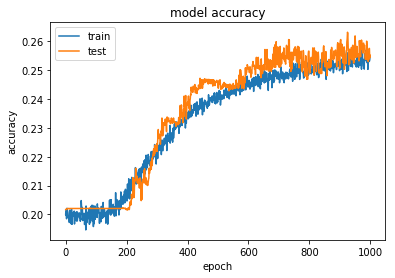

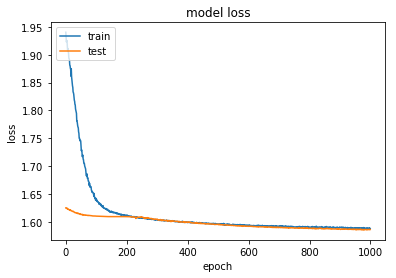

In [25]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
y_predprob = model.predict(x_test)
y_pred = model.predict_classes(x_test)
y_pred_decoded = Headlines.int_to_journal(data, y_pred)

y_trpred = model.predict_classes(x_train)
y_trpred_decoded = Headlines.int_to_journal(data, y_trpred)

In [28]:
#Predicting in the test set
#y_pred = estimator.predict(x_test)
#y_pred_decoded = Headlines.int_to_journal(data, y_pred)
#y_pred = encoder.inverse_transform(predictions)

#y_predprob = estimator.predict_proba(x_test)[:,1]
#y_trpred = estimator.predict(x_train)
#y_trpred_decoded = Headlines.int_to_journal(data, y_trpred)

y_pred

array([4, 4, 4, ..., 4, 4, 3])

In [29]:
#Both y_train and y_test are one-hot-encoded. Decoding them for model reporting.
y_train_tocat = Headlines.onehot_to_categorical(data, y_train)
y_test_tocat = Headlines.onehot_to_categorical(data, y_test)

In [30]:
#Print model report:
print ("\nModel Report")
print ("Accuracy (train set): %.4g" % metrics.accuracy_score(y_train_tocat, y_trpred))
print ("Accuracy (test set): %.4g" % metrics.accuracy_score(y_test_tocat, y_pred))
print("Confusion matrix:")
print (metrics.confusion_matrix(y_test_tocat, y_pred))
print("Detailed classification report:")
print (metrics.classification_report(y_test_tocat, y_pred))


Model Report
Accuracy (train set): 0.2617
Accuracy (test set): 0.2674
Confusion matrix:
[[136  76   0 267 583]
 [103  91   0 210 693]
 [113  80   0 264 619]
 [113  80   0 358 595]
 [ 80  61   0 102 889]]
Detailed classification report:
             precision    recall  f1-score   support

          0       0.25      0.13      0.17      1062
          1       0.23      0.08      0.12      1097
          2       0.00      0.00      0.00      1076
          3       0.30      0.31      0.31      1146
          4       0.26      0.79      0.39      1132

avg / total       0.21      0.27      0.20      5513



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# Evaluating the model with k-Fold Validation
seed=7
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))